# 无循环FBA

该程序的目标是识别无循环的热力学一致的通量状态，顾名思义。您可以在笔记本末尾的部分找到更详细的说明。 [method](#Method) 

In [1]:
%matplotlib inline
import plot_helper

from cobra.io import load_model
from cobra import Reaction, Metabolite, Model
from cobra.flux_analysis.loopless import add_loopless, loopless_solution
from cobra.flux_analysis import pfba

## 无循环解决方案

由于增加了混合整数约束，下面描述的经典无循环方法在计算上成本很高。一种更快、更实用的方法是对通量分布进行后处理，只需将通量设置为零，只要它们可以为零，而不改变模型中任何交换反应的通量。 [CycleFreeFlux](http://dx.doi.org/10.1093/bioinformatics/btv096) 是一种可用于实现此目的的算法，在 cobrapy 中，它是在 `cobra.flux_analysis.loopless_solution`  函数中实现的。`loopless_solution`将识别与原始磁通量分布最接近的磁通量分布（仅使用无循环基本磁通模式）。请注意，这不会删除您明确请求的环路，例如通过强制环路反应携带非零通量。

使用比上面的简单示例更大的模型，可以按如下方式演示

In [2]:
salmonella = load_model('salmonella')
nominal = salmonella.optimize()
loopless = loopless_solution(salmonella)

In [3]:
import pandas

df = pandas.DataFrame(dict(loopless=loopless.fluxes, nominal=nominal.fluxes))

<Axes: xlabel='loopless', ylabel='nominal'>

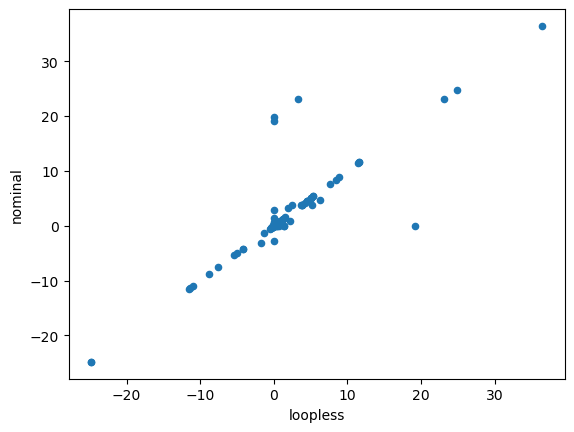

In [4]:
df.plot.scatter(x='loopless', y='nominal')

此功能还可以在 FVA 中使用，通过使用 'loopless=True' 参数来避免反应获得高通量范围，这些反应基本上只有在允许它们参与循环时才能达到高通量（参见模拟笔记本），从而导致更窄的通量范围。

## 无循环模型

Cobrapy 还包括  [Schellenberger et. al.](https://dx.doi.org/10.1016%2Fj.bpj.2010.12.3707) 的“经典”无循环公式。 在 `cobra.flux_analysis.add_loopless`中实现，使用额外的混合整数约束修改模型，使热力学上不可行的循环变得不可能。这比上面提供的策略慢得多，并且只有在以下两种情况之一适用时才应使用：

1. 您希望将非线性（例如二次）目标循与无环条件相结合
2. 您希望强制模型在存在独立于设定的反应边界的循环时不可行。

我用一个玩具模型来演示这一点，该模型有一个，A $\rightarrow$ B $\rightarrow$ C $\rightarrow$ A，w$ A，允许 A 进入系统，允许 C 离开。系统的图形视图如下图所示：

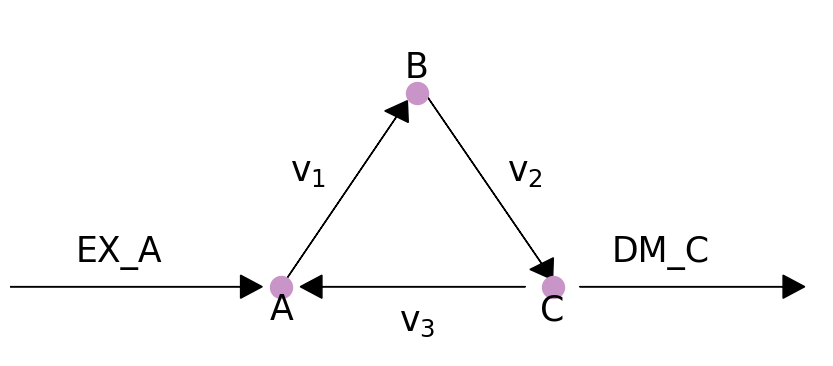

In [5]:
plot_helper.plot_loop()

In [6]:
model = Model()
model.add_metabolites([Metabolite(i) for i in "ABC"])
model.add_reactions([Reaction(i) for i in ["EX_A", "DM_C", "v1", "v2", "v3"]])

model.reactions.EX_A.add_metabolites({"A": 1})
model.reactions.DM_C.add_metabolites({"C": -1})

model.reactions.v1.add_metabolites({"A": -1, "B": 1})
model.reactions.v2.add_metabolites({"B": -1, "C": 1})
model.reactions.v3.add_metabolites({"C": -1, "A": 1})

model.objective = 'DM_C'

虽然此模型包含一个循环，但存在一个通量状态，该通量状态没有通量通过反应$v_3$，并由无循环 FBA 标识。

In [7]:
with model:
    add_loopless(model)
    solution = model.optimize()
print("loopless solution: status = " + solution.status)
print("loopless solution flux: v3 = %.1f" % solution.fluxes["v3"])

loopless solution: status = optimal
loopless solution flux: v3 = 0.0


如果没有通过无循环反应的强制通量，则精简的 FBA 也不会有通量通过环路。

In [8]:
solution = pfba(model)
print("parsimonious solution: status = " + solution.status)
print("loopless solution flux: v3 = %.1f" % solution.fluxes["v3"])

parsimonious solution: status = optimal
loopless solution flux: v3 = 0.0


但是，如果通量被强制通过$v_3$，那么就不再存在可行的无循环解决方案，但简约的解决方案仍将存在。在。

In [9]:
model.reactions.v3.lower_bound = 1
with model:
    add_loopless(model)
    try:
        solution = model.optimize()
    except:
        print('model is infeasible')

d:\ProgramData\anaconda3\Lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [10]:
solution = pfba(model)
print("parsimonious solution: status = " + solution.status)
print("loopless solution flux: v3 = %.1f" % solution.fluxes["v3"])

parsimonious solution: status = optimal
loopless solution flux: v3 = 1.0


## 方法

`loopless_solution`”基于给定的参考通量分布。它将寻找具有以下要求的新的通量分布:
1. 目标值与参考通量相同。
2. 所有交换通量的值都与参考分布中的值相同。
3. 所有非交换通量都具有与参考通量相同的符号（流动方向相同）。
4. 绝对非交换通量的总和最小化。
正如[original publication](http://dx.doi.org/10.1093/bioinformatics/btv096)所证明的那样，这将确定最接近参考通量的“最小环路”解决方案。
若您正在使用add_loopless功能，将采用此处描述的方法[described here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3030201/)。简而言之，该方法会添加近似于ΔG（反应自由能变化）的代理变量G，并通过热力学手段使循环路径不可行。具体实现通过以下公式：

              maximize vobj
              s.t.Sv=0
              lbj ≤ vj ≤ ubj
              -M⋅(1-ai) ≤ vi ≤ M⋅ai
              -1000ai + (1-ai) ≤ Gi ≤ -ai + 1000(1-ai)
              NintG = 0
              ai ∈ {0,1}

  这里，索引j遍历所有反应，而i仅针对内部反应。ai是指标变量，若反应通量为正向则等于1，反之为0。它们用来确保G代理变量的符号总是与实际的ΔG值相反。Nint是内部反应的零空间矩阵，用于找到热力学上“合理”的G值。

  换言之，这个方法聪明地利用了一些数学技巧，在保证反应网络不产生闭环的同时，寻找一个在能量效率上最接近自然状态（即参考通量）的解决方案。它通过引入一些虚拟变量和限制条件，让模型自己去判断哪些反应方向更符合现实世界的热力学法则，从而排除掉那些理论上允许但实际上不可能发生的循环路径。
